In [3]:
# Install Required Packages
# Run this cell first to install all necessary dependencies

# !pip install pandas numpy matplotlib seaborn scikit-learn joblib beautifulsoup4 transformers torch kagglehub

# For GPU support with PyTorch (optional, only if you have CUDA-compatible GPU):
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Alternative installation commands (if you prefer conda):
# !conda install pandas numpy matplotlib seaborn scikit-learn joblib beautifulsoup4 -y
# !conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia -y
# !pip install transformers kagglehub

In [4]:
# Phishing Email Detection Using TF-IDF + SVM and Fine-tuned DistilBERT

# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import re
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch

import kagglehub
from kagglehub import KaggleDatasetAdapter

In [5]:
# 2. Load Dataset
# Dataset: phishing_email.csv from Kaggle

# Set the path to the file you'd like to load
file_path = "phishing_email.csv"

# Load the latest version
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Rename columns to match expected names
df.rename(columns={'text_combined': 'body', 'label': 'label'}, inplace=True)

# Set the variable 'data' with 'df'
data = df

print("First 5 records:", data.head())

First 5 records:                                                 body  label
0  hpl nom may 25 2001 see attached file hplno 52...      0
1  nom actual vols 24 th forwarded sabrae zajac h...      0
2  enron actuals march 30 april 1 201 estimated a...      0
3  hpl nom may 30 2001 see attached file hplno 53...      0
4  hpl nom june 1 2001 see attached file hplno 60...      0


In [6]:
# 3. Preprocessing - Improved

# Remove missing values first
data.dropna(subset=['body', 'label'], inplace=True)

# Define text cleaning function
def clean_email_body(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'\S+@\S+', '', text)  # Remove email addresses
    text = re.sub(r'http\S+', '', text)   # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = text.lower()  # Lowercase
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply cleaning
data['body'] = data['body'].apply(clean_email_body)

# Remove very short emails
data = data[data['body'].str.len() > 20]

# Sample 10,000 rows after cleaning
# data = data.sample(n=20000, random_state=42)

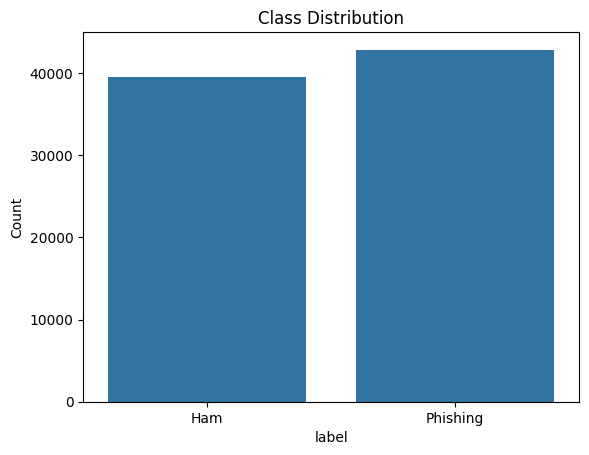

In [7]:
# Visualize label distribution
label_counts = data['label'].value_counts()
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Class Distribution")
plt.xticks([0, 1], ['Ham', 'Phishing'])
plt.ylabel("Count")
plt.savefig("label_distribution_before_sampling.png")
plt.show()

In [8]:
# 4. Train/Test Split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['body'].tolist(), data['label'].tolist(), test_size=0.2, random_state=42)


In [15]:
# Check if GPU is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using device: {device}')

Using device: cpu



=== Logistic Regression Evaluation (TF-IDF) ===
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      7907
           1       0.98      0.98      0.98      8580

    accuracy                           0.98     16487
   macro avg       0.98      0.98      0.98     16487
weighted avg       0.98      0.98      0.98     16487



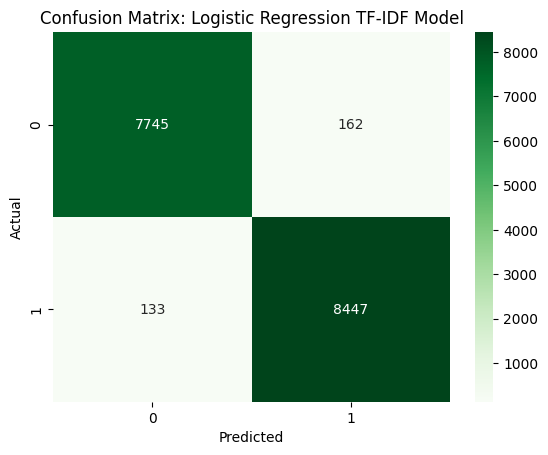

In [12]:
# 5. TF-IDF Feature Extraction
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

# Logistic Regression Model
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, train_labels)
log_preds = log_model.predict(X_test)
print("\n=== Logistic Regression Evaluation (TF-IDF) ===")
print(classification_report(test_labels, log_preds))
joblib.dump(log_model, 'logistic_regression_model.pkl')

log_conf_matrix = confusion_matrix(test_labels, log_preds)
sns.heatmap(log_conf_matrix, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix: Logistic Regression TF-IDF Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('logreg_confusion_matrix.png')
plt.show()


=== Baseline Model Evaluation (TF-IDF + SVM) ===
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      7907
           1       0.98      0.99      0.99      8580

    accuracy                           0.98     16487
   macro avg       0.98      0.98      0.98     16487
weighted avg       0.98      0.98      0.98     16487



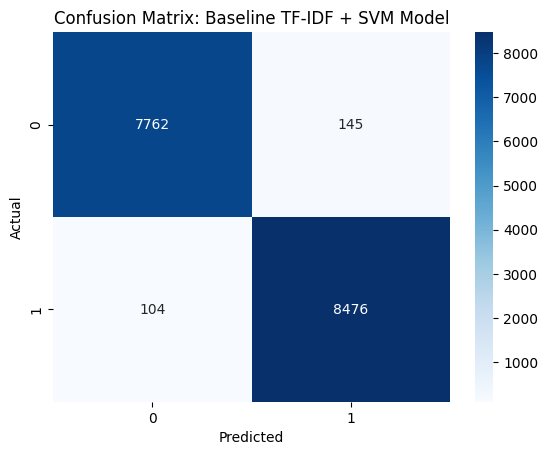

In [ ]:
# Baseline Model: SVM
baseline_model = SVC(kernel='linear', probability=True)
baseline_model.fit(X_train, train_labels)
baseline_preds = baseline_model.predict(X_test)
print("\n=== Baseline Model Evaluation (TF-IDF + SVM) ===")
print(classification_report(test_labels, baseline_preds))
joblib.dump(baseline_model, 'baseline_svm_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

conf_matrix = confusion_matrix(test_labels, baseline_preds)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Baseline TF-IDF + SVM Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('baseline_confusion_matrix.png')
plt.show()

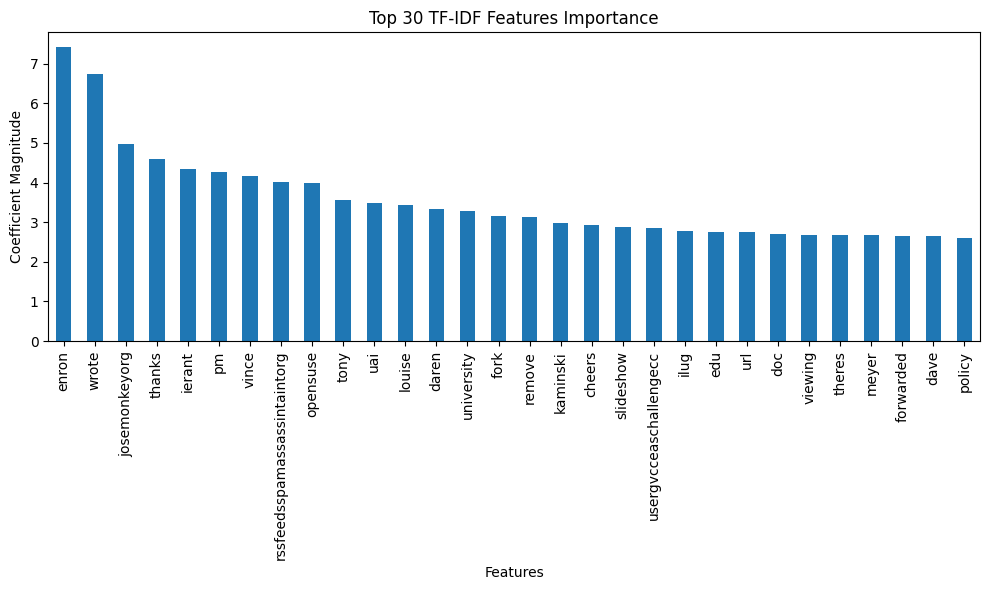

In [ ]:
# TF-IDF Feature Importance
feature_names = vectorizer.get_feature_names_out()
coefficients = np.abs(baseline_model.coef_.toarray()[0])
feature_importance = pd.Series(coefficients, index=feature_names)
feature_importance = feature_importance.sort_values(ascending=False).head(30)

plt.figure(figsize=(10,6))
feature_importance.plot(kind='bar')
plt.title('Top 30 TF-IDF Features Importance')
plt.xlabel('Features')
plt.ylabel('Coefficient Magnitude')
plt.tight_layout()
plt.savefig('tfidf_feature_importance.png')
plt.show()

In [ ]:
# DistilBERT Section...

# Tokenization
train_texts = list(train_texts)
test_texts = list(test_texts)
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

# Dataset Class
class EmailDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = EmailDataset(train_encodings, train_labels)
test_dataset = EmailDataset(test_encodings, test_labels)

# Load Model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Use GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    # evaluation_strategy="epoch",
    logging_dir='./logs',
    logging_steps=1000,
    # load_best_model_at_end=True,
    # report_to="none",
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Fine-tune DistilBERT
trainer.train()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sainadth (sainadth-islander) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
1000,0.191700
2000,0.064900
3000,0.045900
4000,0.038500
5000,0.016400
6000,0.012400
7000,0.011200
8000,0.010400


TrainOutput(global_step=8244, training_loss=0.04760577019587817, metrics={'train_runtime': 1347.7181, 'train_samples_per_second': 97.863, 'train_steps_per_second': 6.117, 'total_flos': 1.7471390143537152e+16, 'train_loss': 0.04760577019587817, 'epoch': 2.0})

In [ ]:
# Evaluate DistilBERT
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

print("=== DistilBERT Model Evaluation ===")
print(classification_report(test_labels, preds))

# Save DistilBERT model
model.save_pretrained('distilbert_phishing_model')
tokenizer.save_pretrained('distilbert_phishing_tokenizer')

=== DistilBERT Model Evaluation ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7907
           1       1.00      0.99      1.00      8580

    accuracy                           1.00     16487
   macro avg       0.99      1.00      1.00     16487
weighted avg       1.00      1.00      1.00     16487



('distilbert_phishing_tokenizer/tokenizer_config.json',
 'distilbert_phishing_tokenizer/special_tokens_map.json',
 'distilbert_phishing_tokenizer/vocab.txt',
 'distilbert_phishing_tokenizer/added_tokens.json',
 'distilbert_phishing_tokenizer/tokenizer.json')

DistilBERT ROC-AUC: 0.9997342504045427


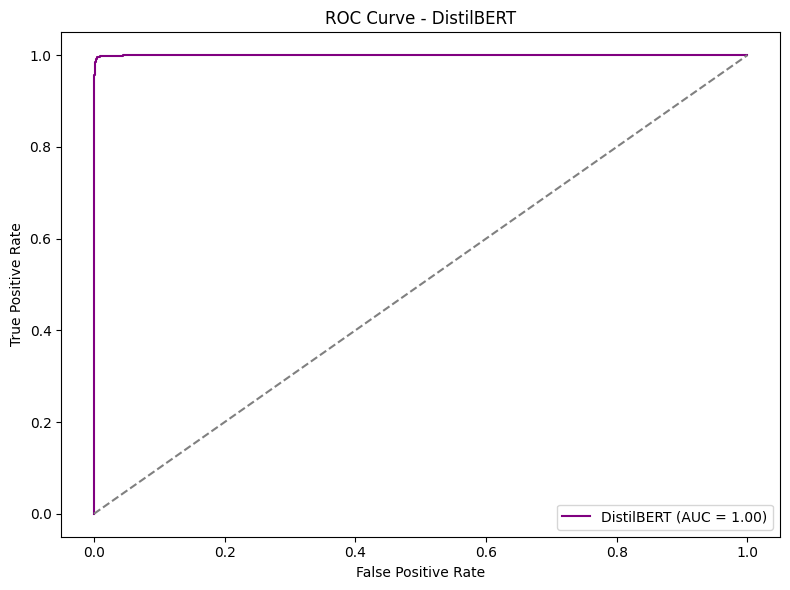

In [ ]:
# ROC Curve for DistilBERT

from sklearn.metrics import roc_curve, roc_auc_score
bert_probs = predictions.predictions[:, 1]
print("DistilBERT ROC-AUC:", roc_auc_score(test_labels, bert_probs))


fpr, tpr, _ = roc_curve(test_labels, bert_probs)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='purple', label=f'DistilBERT (AUC = {roc_auc_score(test_labels, bert_probs):.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - DistilBERT')
plt.legend()
plt.tight_layout()
plt.savefig('distilbert_roc_curve.png')
plt.show()

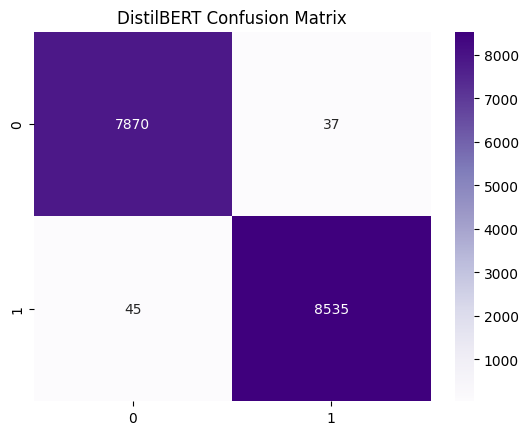

In [ ]:
# Confusion Matrix
sns.heatmap(confusion_matrix(test_labels, preds), annot=True, fmt='d', cmap='Purples')
plt.title("DistilBERT Confusion Matrix")
plt.savefig("distilbert_confusion_matrix.png")
plt.show()

0.9820464608479408 0.9848971917268151 0.9950263844240917


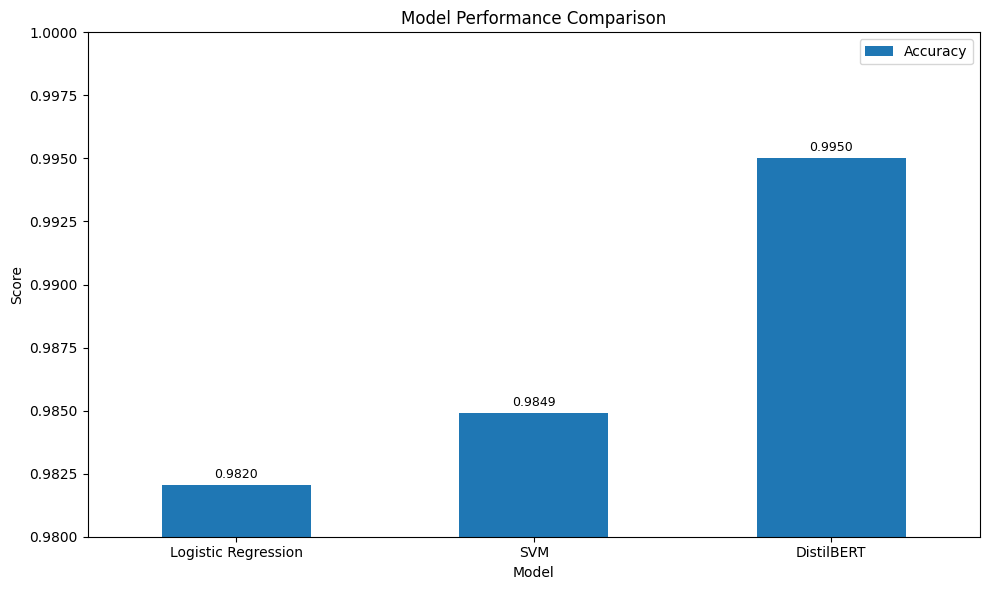

In [ ]:
# Comparison Graph
log_accuracy = accuracy_score(test_labels, log_preds)
svm_accuracy = accuracy_score(test_labels, baseline_preds)
bert_accuracy = accuracy_score(test_labels, preds)
print(log_accuracy, svm_accuracy, bert_accuracy)
metrics_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVM', 'DistilBERT'],
    'Accuracy': [log_accuracy, svm_accuracy, bert_accuracy],
})

metrics_ax = metrics_df.set_index('Model').plot(kind='bar', figsize=(10,6))
for p in metrics_ax.patches:
    metrics_ax.annotate(f"{p.get_height():.4f}", (p.get_x() + p.get_width()/2., p.get_height()),
                        ha='center', va='bottom', fontsize=9, color='black', xytext=(0, 3),
                        textcoords='offset points')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0.98, 1.0)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

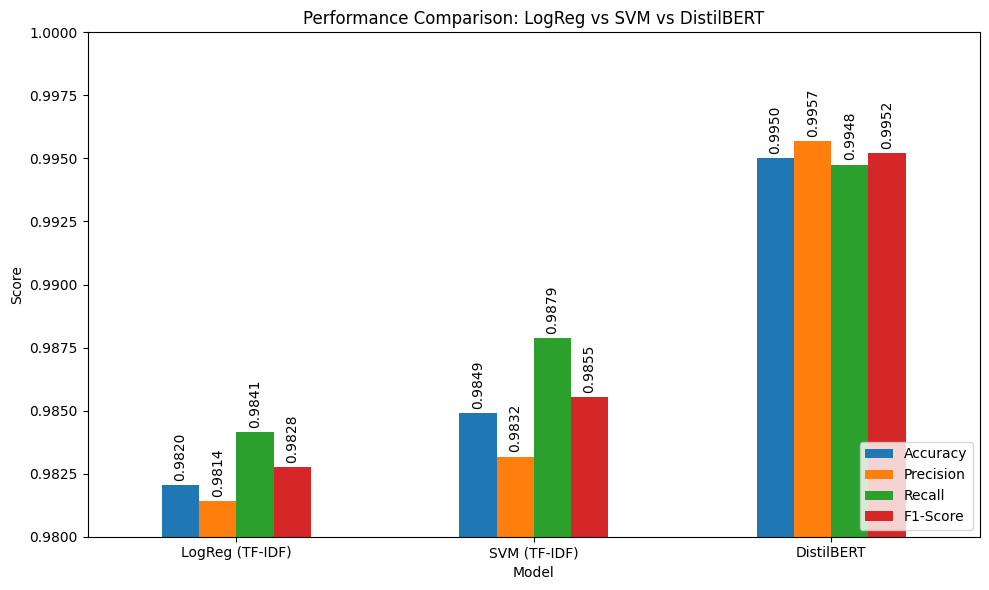

In [ ]:
9# Final Comparison Graph: Logistic Regression vs SVM vs DistilBERT
log_accuracy = accuracy_score(test_labels, log_preds)
log_precision, log_recall, log_f1, _ = precision_recall_fscore_support(test_labels, log_preds, average='binary')

svm_accuracy = accuracy_score(test_labels, baseline_preds)
svm_precision, svm_recall, svm_f1, _ = precision_recall_fscore_support(test_labels, baseline_preds, average='binary')

distilbert_accuracy = accuracy_score(test_labels, preds)
distilbert_precision, distilbert_recall, distilbert_f1, _ = precision_recall_fscore_support(test_labels, preds, average='binary')

# Create DataFrame (as in your existing code)
metrics_df = pd.DataFrame({
    'Model': ['LogReg (TF-IDF)', 'SVM (TF-IDF)', 'DistilBERT'],
    'Accuracy': [log_accuracy, svm_accuracy, distilbert_accuracy],
    'Precision': [log_precision, svm_precision, distilbert_precision],
    'Recall': [log_recall, svm_recall, distilbert_recall],
    'F1-Score': [log_f1, svm_f1, distilbert_f1]
})

# Plot
ax = metrics_df.set_index('Model').plot(kind='bar', figsize=(10, 6))
plt.title('Performance Comparison: LogReg vs SVM vs DistilBERT')
plt.ylabel('Score')
plt.ylim(0.98, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()

# Add value labels on bars (rotated vertically)
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', label_type='edge', rotation=90, padding=3)

plt.savefig('final_model_comparison.png')
plt.show()

In [ ]:

# === Sample Email Testing ===

sample_emails = [
    "Please confirm your account by clicking the link below. Your password has been compromised.",
    "Meeting rescheduled to 3PM tomorrow. Let me know if you have any conflicts.",
    "Urgent: Your bank account has been locked. Visit our site to verify your credentials."
]

# Preprocess
sample_cleaned = [clean_email_body(email) for email in sample_emails]

# TF-IDF predictions
sample_vectorized = vectorizer.transform(sample_cleaned)
print("TF-IDF + Logistic Regression Predictions:", log_model.predict(sample_vectorized))
print("TF-IDF + SVM Predictions:", baseline_model.predict(sample_vectorized))

# DistilBERT predictions
sample_tokens = tokenizer(sample_emails, truncation=True, padding=True, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**sample_tokens)
    distil_preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
print("DistilBERT Predictions:", distil_preds)


TF-IDF + Logistic Regression Predictions: [1 0 1]
TF-IDF + SVM Predictions: [1 0 1]
DistilBERT Predictions: [1 0 1]


In [ ]:
# Add challenging email

challenging_emails = [
    "Your SSO session has been extended for administrative reasons. No action is required unless prompted.",
    "IT has pushed a silent patch for enhanced security. A reboot may be triggered during off-hours.",
    "Your email quota has been exceeded. Archived messages will be moved.",
    "We’ve enabled two-factor authentication for added protection. Confirm setup at your next login.",
]


# Preprocess emails
challenging_cleaned = [clean_email_body(email) for email in challenging_emails]

# TF-IDF predictions
challenging_vectorized = vectorizer.transform(challenging_cleaned)
log_preds = log_model.predict(challenging_vectorized)
svm_preds = baseline_model.predict(challenging_vectorized)

# DistilBERT predictions
challenging_tokens = tokenizer(challenging_emails, truncation=True, padding=True, return_tensors="pt").to(device)
with torch.no_grad():
    challenging_outputs = model(**challenging_tokens)
    bert_preds = torch.argmax(challenging_outputs.logits, dim=1).cpu().numpy()

# Print predictions
print("=== Challenging Emails Test ===")
for i, email in enumerate(challenging_emails):
    print(f"Email {i+1}: {email}")
    print(f"Logistic Regression Prediction: {log_preds[i]}")
    print(f"SVM Prediction: {svm_preds[i]}")
    print(f"DistilBERT Prediction: {bert_preds[i]}")
    print()


=== Challenging Emails Test ===
Email 1: Your SSO session has been extended for administrative reasons. No action is required unless prompted.
Logistic Regression Prediction: 1
SVM Prediction: 1
DistilBERT Prediction: 0

Email 2: IT has pushed a silent patch for enhanced security. A reboot may be triggered during off-hours.
Logistic Regression Prediction: 0
SVM Prediction: 0
DistilBERT Prediction: 1

Email 3: Your email quota has been exceeded. Archived messages will be moved.
Logistic Regression Prediction: 1
SVM Prediction: 1
DistilBERT Prediction: 0

Email 4: We’ve enabled two-factor authentication for added protection. Confirm setup at your next login.
Logistic Regression Prediction: 0
SVM Prediction: 0
DistilBERT Prediction: 1



In [ ]:
# === Save All Outputs to Zip ===
import zipfile, os

files_to_zip = [
    'logistic_regression_model.pkl',
    'baseline_svm_model.pkl',
    'tfidf_vectorizer.pkl',
    'label_distribution_before_sampling.png',
    'label_distribution_after_sampling.png',
    'logreg_confusion_matrix.png',
    'baseline_confusion_matrix.png',
    'tfidf_feature_importance.png',
    'distilbert_confusion_matrix.png',
    'distilbert_roc_curve.png',
    'model_comparison.png'
]

with zipfile.ZipFile('phishing_model_outputs.zip', 'w') as zipf:
    for file in files_to_zip:
        if os.path.exists(file):
            zipf.write(file)
print("Saved all models and outputs to phishing_model_outputs.zip")

Saved all models and outputs to phishing_model_outputs.zip


In [ ]:
model.save_pretrained("distilbert_model")
tokenizer.save_pretrained("distilbert_model")

# Zip the folder
import shutil
shutil.make_archive("distilbert_model", 'zip', "distilbert_model")


'/content/distilbert_model.zip'